In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import matplotlib.pyplot as plt
import lalsimulation as lalsim

from pycbc.filter.matchedfilter import match, optimized_match
from pycbc.types import FrequencySeries

from bilby_lisa.source import lisa_binary_black_hole
from bilby_lisa.source_LW import lisa_binary_black_hole_LW, lisa_binary_black_hole_pseob_LW
from bilby_lisa.source_TD import lisa_binary_black_hole_TD, lisa_binary_black_hole_pseob_TD

from lisatools.sensitivity import get_sensitivity
from bbhx.utils.transform import LISA_to_SSB

import seaborn as sns

sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="deep",
    font_scale=1.25,
)

In [3]:
import os

os.environ["LAL_DATA_PATH"] = "/home/cbc/ROM_data"

In [4]:
Mtot = 2e7
q = 2
m1 = q / (1 + q) * Mtot
m2 = 1 / (1 + q) * Mtot
s1x = 0.0
s1y = 0.0
s1z = 0.2
s2x = 0.0
s2y = 0.0
s2z = 0.1
phiRef = 0.0
distance = 50 * 1e3
inclination = np.pi / 3

f_max = 0.0025 / (Mtot/2e7)
f_ref = 1e-4 / (Mtot/2e7)
f_min = 1e-4 / (Mtot/2e7)
deltaF = 1/262800.0 # 0.1 month duration

frequency_array = np.arange(0.0, f_max, deltaF)

ra = np.pi / 3
dec = np.pi / 3
psi = np.pi / 3

geocent_time = 0.0

In [5]:
dict_bbhx = lisa_binary_black_hole(
    frequency_array, m1, m2, distance, s1z, s2z,
    inclination, phiRef, ra, dec, psi, geocent_time,
    reference_frequency=f_ref, minimum_frequency=f_min, maximum_frequency = f_max
)

# dict_bbhx_2 = lisa_binary_black_hole(
#     frequency_array, m1, m2, distance, s1z, s2z,
#     inclination, phiRef, ra, dec, psi, geocent_time + 100.0,
#     reference_frequency=f_ref, minimum_frequency=f_min
# )

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [6]:
(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2) = (
    lalsim.SimInspiralTransformPrecessingWvf2PE(
        inclination, s1x, s1y, s1z, s2x, s2y, s2z, m1, m2, f_ref, phiRef
    )
)

In [7]:
dict_lw = lisa_binary_black_hole_LW(
    frequency_array, m1, m2, distance, 
    a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
    ra, dec, psi, geocent_time, waveform_approximant = "IMRPhenomD", 
    reference_frequency=f_ref, minimum_frequency=f_min, maximum_frequency = f_max
)

/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [8]:
geocent_time_ssb, ra_ssb, dec_ssb, psi_ssb = LISA_to_SSB(0.0, np.pi/3, np.pi/3, np.pi/3)

In [9]:
geocent_time_ssb, ra_ssb, dec_ssb, psi_ssb

(-311.88469873224625,
 2.5356327271216195,
 0.7069211022664601,
 2.7830844194777407)

In [10]:
dict_td = lisa_binary_black_hole_TD(
    frequency_array, m1, m2, distance, 
    a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
    ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb, waveform_approximant = "IMRPhenomD", 
    reference_frequency=f_ref, minimum_frequency=f_min, maximum_frequency = f_max
)

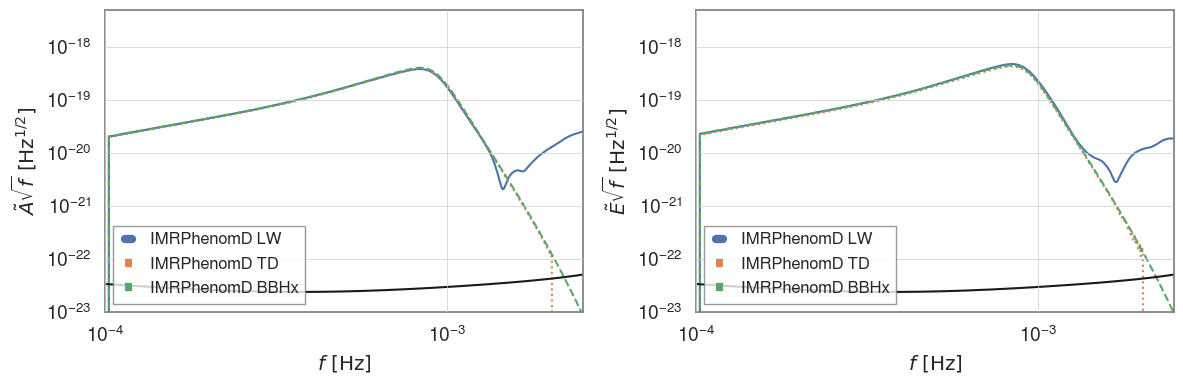

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_A"]), label = "IMRPhenomD LW")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_A"]), label = "IMRPhenomD TD", ls = ':')
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_A"]), label = "IMRPhenomD BBHx", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_E"]), label = "IMRPhenomD LW")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_E"]), label = "IMRPhenomD TD", ls = ':')
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_E"]), label = "IMRPhenomD BBHx", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=3, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()

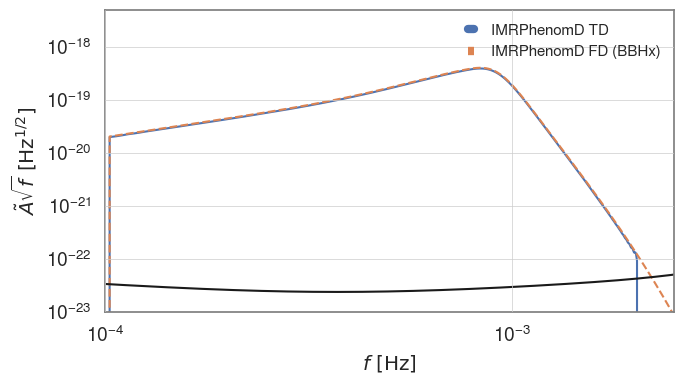

In [12]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (7,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_A"]), label = "IMRPhenomD TD")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_A"]), label = "IMRPhenomD FD (BBHx)", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=1, fontsize=11, frameon=False)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()

# plt.savefig("response_1.png", bbox_inches="tight", dpi=200)

In [13]:
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens 
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

In [14]:
data = DataResidualArray([dict_lw["LISA_A"], dict_lw["LISA_E"]], f_arr=frequency_array)

In [15]:
sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi *

In [16]:
analysis = AnalysisContainer(data, sens_mat)

In [17]:
analysis.snr()

822.7207916038737

In [18]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_bbhx["LISA_A"], deltaF),
        FrequencySeries(dict_lw["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
        subsample_interpolation=True,
    )[0]
)

0.0010113908422217932


In [19]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_td["LISA_A"], deltaF),
        FrequencySeries(dict_lw["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
        subsample_interpolation=True,
    )[0]
)

0.0009953718181482385


/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi *

In [20]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_td["LISA_A"], deltaF),
        FrequencySeries(dict_bbhx["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
        subsample_interpolation=True,
    )[0]
)

2.412122833361785e-06


In [21]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- optimized_match(
        FrequencySeries(dict_td["LISA_A"], deltaF),
        FrequencySeries(dict_bbhx["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
    )[0]
)

lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
3.3120059816926783e-07


In [22]:
dict_seob = lisa_binary_black_hole_TD(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb, 
                                       waveform_approximant = "SEOBNRv5PHM", 
                                       reference_frequency=f_ref, minimum_frequency=f_min, maximum_frequency = f_max
                                       # mode_array=[(2,2)]
                                       )

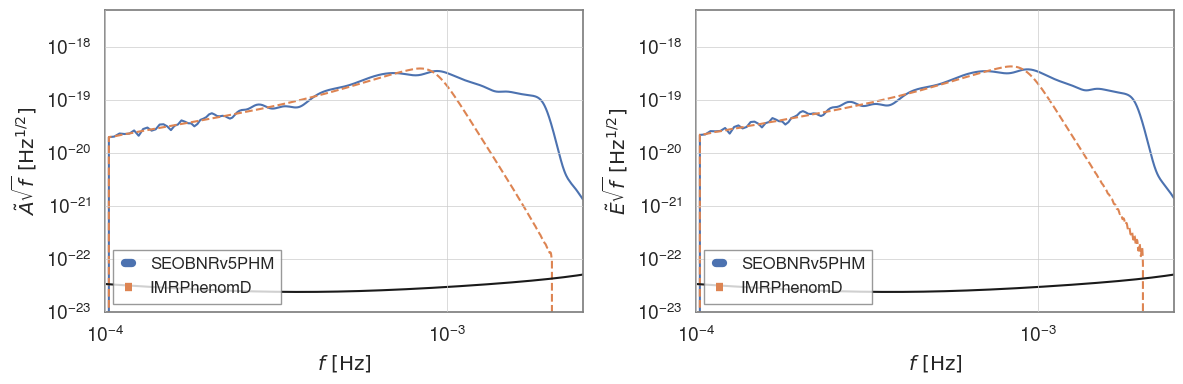

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOBNRv5PHM")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_A"]), label = "IMRPhenomD", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_E"]), label = "SEOBNRv5PHM")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_E"]), label = "IMRPhenomD", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=3, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


In [24]:
domega220 = 0.1
dtau220 = 0.1

domega330 = 0.1
dtau330 = 0.1
domega210 = 0.1
dtau210 = 0.1
domega440 = 0.1
dtau440 = 0.1
domega550 = 0.1
dtau550 = 0.1
domega320 = 0.1
dtau320 = 0.1
domega430 = 0.1
dtau430 = 0.1
dA22 = 0
dw22 = 0
dA33 = 0
dw33 = 0
dA21 = 0
dw21 = 0
dA44 = 0
dw44 = 0
dA55 = 0
dw55 = 0
dA32 = 0
dw32 = 0
dA43 = 0
dw43 = 0
dTpeak = 0
da6 = 0
ddSO = 0

In [25]:
dict_pseob = lisa_binary_black_hole_pseob_TD(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb, 
                                       domega220, dtau220, domega330, dtau330, domega210, dtau210, 
                                       domega440, dtau440, domega550, dtau550, domega320, dtau320, 
                                       domega430, dtau430, dA22, dw22, dA33, dw33, dA21, dw21, dA44, 
                                       dw44, dA55, dw55, dA32, dw32, dA43, dw43, dTpeak, da6, ddSO,
                                       waveform_approximant = "SEOBNRv5PHM", 
                                       reference_frequency=f_ref, minimum_frequency=f_min, maximum_frequency = f_max
                                       # mode_array=[(2,2)]
                                       )

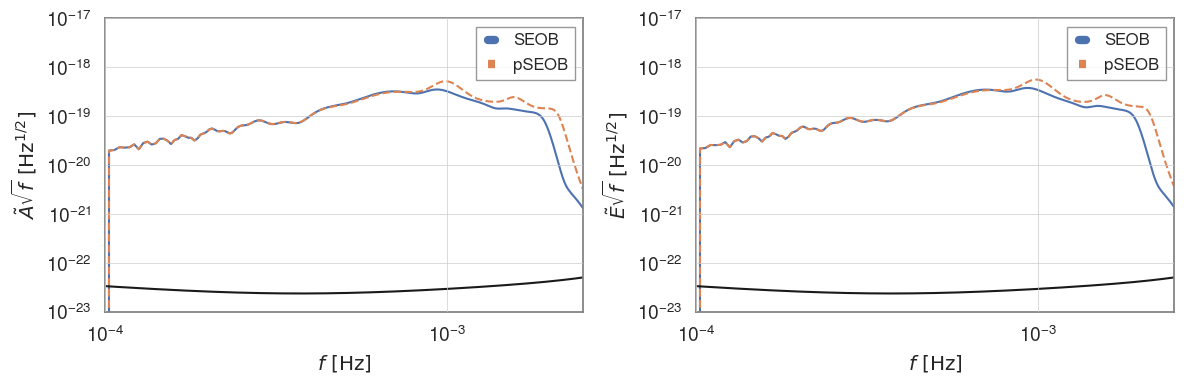

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOB")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_A"]), label = "pSEOB", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_E"]), label = "SEOB")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_E"]), label = "pSEOB", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 1e-17)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=1, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


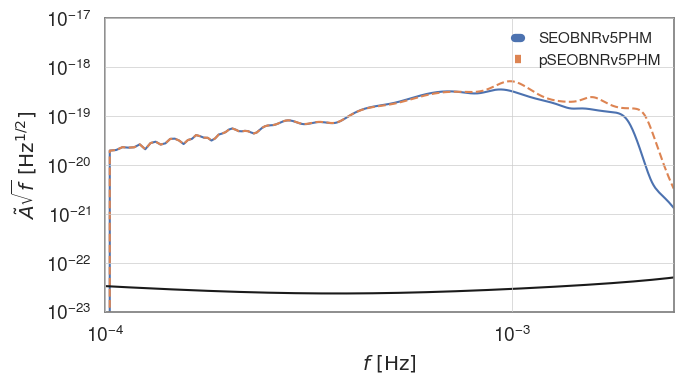

In [27]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (7,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOBNRv5PHM")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_A"]), label = "pSEOBNRv5PHM", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

for ax in [ax1]:
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 1e-17)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=1, fontsize=11, frameon=False)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()
# plt.savefig("response_2.png", bbox_inches="tight", dpi=200)

In [28]:
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens 
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

In [29]:
data = DataResidualArray([dict_pseob["LISA_A"], dict_pseob["LISA_E"]], f_arr=frequency_array)

In [30]:
sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/home/lpompili/.conda/envs/pSEOB_LISA/lib/python3.11/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi *

In [31]:
analysis = AnalysisContainer(data, sens_mat)

In [32]:
analysis.snr()

1092.6193586964578

In [33]:
template = DataResidualArray([dict_seob["LISA_A"], dict_seob["LISA_E"]], f_arr=frequency_array)

In [34]:
analysis.template_snr(template)

(895.9990966568582, 936.5909440486479)

In [35]:
analysis.template_likelihood(template)

-159131.08229949977

In [36]:
geocent_time_ssb, ra_ssb, dec_ssb, psi_ssb = LISA_to_SSB(0.0, np.pi/3, np.pi/3, np.pi/3)

In [37]:
dict_seob = lisa_binary_black_hole_TD(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb, 
                                       waveform_approximant = "SEOBNRv5HM", 
                                       reference_frequency=f_ref, minimum_frequency=f_min, maximum_frequency = f_max
                                       )

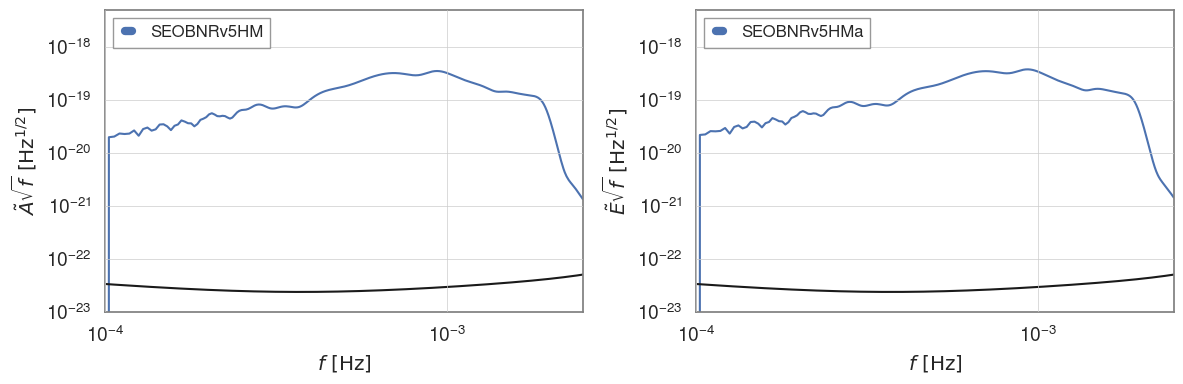

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOBNRv5HM")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_E"]), label = "SEOBNRv5HM")

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=2, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()

In [39]:
phiRef

0.0

In [60]:
dict_seob = lisa_binary_black_hole_TD(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb, 
                                       waveform_approximant = "NRHybSur3dq8", 
                                       reference_frequency=f_ref, minimum_frequency=f_min, maximum_frequency = f_max
                                       )

In [61]:
data = DataResidualArray([dict_seob["LISA_A"], dict_seob["LISA_E"]], f_arr=frequency_array)

In [62]:
sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

In [63]:
analysis = AnalysisContainer(data, sens_mat)

In [64]:
x_arr = np.linspace(-2000, 2000, 101)
logl = []

for x in x_arr:
    dict_templ = lisa_binary_black_hole_TD(frequency_array, m1, m2, distance, 
                                        a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                        ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb + x, 
                                        waveform_approximant = "IMRPhenomTHM", 
                                        reference_frequency=f_ref, minimum_frequency=f_min, maximum_frequency = f_max
                                        )

    template = DataResidualArray([dict_templ["LISA_A"], dict_templ["LISA_E"]], f_arr=frequency_array)

    logl.append(analysis.template_likelihood(template))

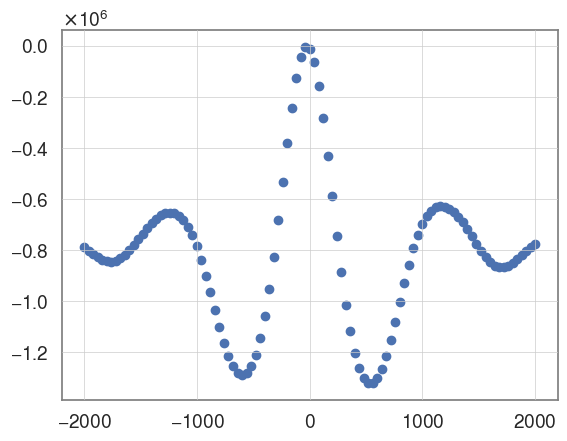

In [65]:
plt.scatter(x_arr, logl)

In [66]:
x_arr = np.linspace(0, 2 * np.pi, 101)
logl = []

for x in x_arr:
    dict_templ = lisa_binary_black_hole_TD(frequency_array, m1, m2, distance, 
                                        a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef + x, 
                                        ra_ssb, dec_ssb, psi_ssb, geocent_time_ssb, 
                                        waveform_approximant = "IMRPhenomTHM", 
                                        reference_frequency=f_ref, minimum_frequency=f_min, maximum_frequency = f_max
                                        )

    template = DataResidualArray([dict_templ["LISA_A"], dict_templ["LISA_E"]], f_arr=frequency_array)

    logl.append(analysis.template_likelihood(template))

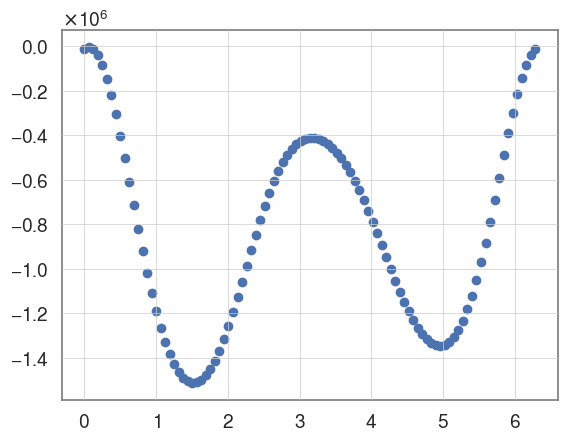

In [67]:
plt.scatter(x_arr, logl)